In [1]:
import numpy as np
from matplotlib import pyplot as plt

# 4

In [ ]:
d   = 100
n   = 10
n_t = 1000

X   = np.random.normal(loc=0.,
                       scale=1.,
                       size=(d,n))
X_t = np.random.normal(loc=0.,
                       scale=1.,
                       size=(d,n_t))
g = lambda X : np.mean(X + np.sin(10. * X), axis=0)
relu = lambda z, k : np.sqrt(2/k) * np.maximum(0, z)

y   = g(X)
y_t = g(X_t)

## (a)

Let $\boldsymbol{w} = \begin{bmatrix} a_1 & a_2 & \ldots & a_k & b_{11} & \ldots & b_{1d} & b_{21} & \ldots & b_{kd} \end{bmatrix}^\mathsf{T} \in \mathbb{R}^{k+kd}$ be the initial weight of a neural network (NN) $f$,<br>
then the *linearization* of $f$ around initial weight $\boldsymbol{w}^{(0)}$is
$$
\tilde{f}_\boldsymbol{x}(\boldsymbol{w}) = f_\boldsymbol{x}(\boldsymbol{w}^{(0)}) + \nabla f_\boldsymbol{x} \left( \boldsymbol{w}^{(0)} \right)^\mathsf{T} \left( \boldsymbol{w} - \boldsymbol{w}^{(0)} \right)
$$
which is
$$
\tilde{f}_\boldsymbol{x}(\boldsymbol{w}) \color{green}{- f_\boldsymbol{x}(\boldsymbol{w}^{(0)})} = \nabla f_\boldsymbol{x} \left( \boldsymbol{w}^{(0)} \right)^\mathsf{T} \left( \boldsymbol{w} \color{gray}{- \boldsymbol{w}^{(0)}} \right)
$$

In [ ]:
def generate_weights(k=2048, d=100):
    A = np.random.normal(loc=0.,
                         scale=1.,
                         size=(1,k))
    B = np.random.normal(loc=0.,
                         scale=1.,
                         size=(k,d))
    return A, B

In [ ]:
A, B = generate_weights()
y_diff = y - A @ relu(B @ X)

## (b) and (c)

$$
f_\boldsymbol{x}(\boldsymbol{w}) = \sum_{i=1}^k a_i \phi \left( \sum_{j=1}^d b_{ij} x_j \right)
$$
then
$$
\nabla f_\boldsymbol{x} \left( \boldsymbol{w}^{(0)} \right)
=
\begin{bmatrix}
\sum_{j=1}^d b_{1j} x_j \\
\sum_{j=1}^d b_{2j} x_j \\
\vdots \\
\sum_{j=1}^d b_{kj} x_j \\
a_1 x_1 \phi' \left( \sum_{j=1}^d b_{1j} x_j \right) \\
a_1 x_2 \phi' \left( \sum_{j=1}^d b_{1j} x_j \right) \\
\vdots \\
a_1 x_d \phi' \left( \sum_{j=1}^d b_{1j} x_j \right) \\
a_2 x_1 \phi' \left( \sum_{j=1}^d b_{2j} x_j \right) \\
\vdots \\
a_k x_d \phi' \left( \sum_{j=1}^d b_{kj} x_j \right)
\end{bmatrix}
=
\mathbf{B}\boldsymbol{x}
\ \color{green}{\verb|concat|} \
\boldsymbol{x}\mathbf{A} \otimes \phi \left( \mathbf{B}\boldsymbol{x} \right)^\mathsf{T}
$$
where $\left( \mathbf{B}\boldsymbol{x} \right)^\mathsf{T}$ is broadcast to the shape of $\boldsymbol{x}\mathbf{A}$, and $\otimes$ is element-wise multiplication. Hence, the kernel is
$$
K_E (\boldsymbol{x}, \tilde{\boldsymbol{x}})
=
{\nabla f_\boldsymbol{x} \left( \boldsymbol{w}^{(0)} \right)}^\mathsf{T}
\nabla f_\tilde{\boldsymbol{x}} \left( \boldsymbol{w}^{(0)} \right)
$$

In [ ]:
def d_relu(x):
    """ derivative of ReLU """
    x[x > 0.] = 1.
    x[x < 0.] = 0.

In [ ]:
def f_grad(x, k=2048, A_0=A, B_0=B):
    num = x.shape[-1] # n
    Z_T = (B @ x).T # shape: (n, n, k)
    f_grad = np.concatenate((Z_T,
                             np.reshape((x.T[..., None] @ A) * np.broadcast_to(d_relu(Z_T)[..., None, :],
                                                                               shape=(num,num,d,k)), # shape: (n, n, d, k)
                                        newshape=(num,num,-1))), # shape: (n, n, dk)
                            axis=-1) # shape: (n, n, k+dk)
    return f_grad

def emp_ntk(x, x_tilde,
            A_0=A, B_0=B):
    f_grad_x       = f_grad(x)
    f_grad_x_tilde = f_grad(x_tilde)
    emp_ker = np.sum(f_grad_x * f_grad_x_tilde,
                     axis=-1) # shape: (n, n)
    return emp_ker

Let $\tilde{\boldsymbol{y}} := \boldsymbol{y} - f_\boldsymbol{x}(\boldsymbol{w}^{(0)})$ be the adjusted labels,<br>
and given the empirical kernel $K_E (\boldsymbol{x}, \tilde{\boldsymbol{x}})$,<br>
the predictor is
$$
\hat{\boldsymbol{y}} = \underbrace{\tilde{\boldsymbol{y}} \hat{\mathbf{K}}_E^{-1}}_\boldsymbol{\tilde{\alpha}} \ \hat{\mathbf{K}}_E \left( \mathbf{X}, \boldsymbol{x} \right) + f_\boldsymbol{x}(\boldsymbol{w}^{(0)})
$$

In [ ]:
def predict(X_test=X_t,
            X_train=X, y_train=y_diff, ker=emp_ntk):
    X_expand   = np.broadcast_to(X[:, None, :]  , (d,n,n))
    X_t_expand = np.broadcast_to(X_t[:, None, :], (d,n,n_t))

    K_E_hat = emp_ntk(X_expand,
                      X_expand.transpose((0,2,1)))
    alpha = np.linalg.solve(K_E_hat, y_diff) # shape: (1, n)
    K_hat_x = emp_ntk(X, X_t_expand).T # shape: (n, n_t)

    return np.sum(alpha * K_hat_x, axis=-1) + A @ relu(B @ X_t)

In [ ]:
mse = lambda y_t, y_pred : np.mean(np.square(y_t - y_pred))

In [ ]:
y_pred = predict()
mse(y_t, y_pred)

## (d)

### PyTorch

Follow the configuration below to use GPU runtime on Colab

$$
\verb|Runtime| \longrightarrow \verb|Change runtime type| \longrightarrow \verb|Hardware accelerator: GPU| \longrightarrow \verb|Save|
$$

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if   torch.cuda.is_available()
                             else 'cpu')

In [ ]:
class net(nn.Module):
    def __init__(self, num_hidden, in_dim=d):
        super(net, self).__init__()
        self.d  = in_dim
        self.k  = num_hidden
        self.fc = nn.Sequential(
            nn.Linear(self.d, self.k), nn.ReLU(),
            nn.Linear(self.k, 1)
        )
    def forward(self, x):
        return self.fc(x)

### My implementation

## (e)

# 5

# 6

Install [JAX](https://github.com/google/jax)

In [2]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

  Preparing metadata (setup.py) ... done


Libraries

In [3]:
import jax.numpy as jnp

from jax import random
from jax import jit

import neural_tangents as nt
from neural_tangents import stax

Load [CIFAR10](http://www.cs.toronto.edu/~kriz/cifar.html) through PyTorch.

In [4]:
import torchvision

training_set = torchvision.datasets.CIFAR10(root='./cifar',
                                            train=True,
                                            download=True,
                                            transform=None)
test_set = torchvision.datasets.CIFAR10(root='./cifar',
                                        train=False,
                                        download=True,
                                        transform=None)

Files already downloaded and verified
Files already downloaded and verified


Label `'cat'` has index $\verb|3|$, and `'dog'` has index $\verb|5|$.

In [5]:
X_train = np.empty(shape=(int(1e4),32,32,3),
                   dtype=np.float32)
y_train = np.zeros(shape=(int(1e4),10),
                   dtype=np.float32)
idx = 0
for i in range(len(training_set)):
    if training_set[i][1] == 3 or training_set[i][1] == 5:
        X_train[idx] = training_set[i][0]
        y_train[idx][ training_set[i][1] ] = 1. # Labels are initially not one-hot encoded.
        idx += 1
X_train, y_train = jnp.array(X_train), jnp.array(y_train)

In [6]:
X_test = np.empty(shape=(int(2e3),32,32,3),
                  dtype=np.float32)
y_test = np.zeros(shape=(int(2e3),10),
                  dtype=np.float32)
idx = 0
for i in range(len(test_set)):
    if test_set[i][1] == 3 or test_set[i][1] == 5:
        X_test[idx] = test_set[i][0]
        y_test[idx][test_set[i][1]] = 1. # Labels are initially not one-hot encoded.
        idx += 1
X_test, y_test = jnp.array(X_test), jnp.array(y_test)

## (a)

Flatten input images

In [32]:
X_train = jnp.reshape(X_train,
                      newshape=(int(1e4),-1))
X_test = jnp.reshape(X_test,
                     newshape=(int(2e3),-1))
acc = []

#### 1 hidden layer

As per lines $\verb|763|$ to $\verb|765|$ in [`linear.py`](https://github.com/google/neural-tangents/blob/main/neural_tangents/_src/stax/linear.py), `out_dim` is ignored in `ntk` mode.

In [11]:
_, _, ker_fn_1 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=10)
)

ker_fn_1 = jit(ker_fn_1, static_argnames='get')

In [50]:
pred_fn_1 = nt.predict.gradient_descent_mse_ensemble(ker_fn_1,
                                                     X_train, y_train)
mean_1 = pred_fn_1(x_test=X_test,
                   get='ntk', compute_cov=False)
acc.append(jnp.sum(jnp.sum((mean_1 > .5) == (y_test > .5), axis=1) == 10) / 2000)

### 3 hidden layers

In [51]:
_, _, ker_fn_3 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=10)
)

ker_fn_3 = jit(ker_fn_3, static_argnames='get')

In [52]:
pred_fn_3 = nt.predict.gradient_descent_mse_ensemble(ker_fn_3,
                                                     X_train, y_train)
mean_3 = pred_fn_3(x_test=X_test,
                   get='ntk', compute_cov=False)
acc.append(jnp.sum(jnp.sum((mean_3 > .5) == (y_test > .5), axis=1) == 10) / 2000)

### 5 hidden layers

In [53]:
_, _, ker_fn_5 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=10)
)

ker_fn_5 = jit(ker_fn_5, static_argnames='get')

In [54]:
pred_fn_5 = nt.predict.gradient_descent_mse_ensemble(ker_fn_5,
                                                     X_train, y_train)
mean_5 = pred_fn_5(x_test=X_test,
                   get='ntk', compute_cov=False)
acc.append(jnp.sum(jnp.sum((mean_5 > .5) == (y_test > .5), axis=1) == 10) / 2000)

### 7 hidden layers

In [56]:
_, _, ker_fn_7 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=512), stax.Relu(),
    stax.Dense(out_dim=10)
)

ker_fn_7 = jit(ker_fn_7, static_argnames='get')

In [57]:
pred_fn_7 = nt.predict.gradient_descent_mse_ensemble(ker_fn_7,
                                                     X_train, y_train)
mean_7 = pred_fn_7(x_test=X_test,
                   get='ntk', compute_cov=False)
acc.append(jnp.sum(jnp.sum((mean_7 > .5) == (y_test > .5), axis=1) == 10) / 2000)

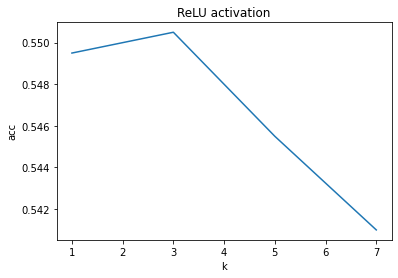

In [59]:
plt.plot((1,3,5,7), acc)
plt.title('ReLU activation')
plt.xlabel('k')
plt.ylabel('acc')
plt.show()

## (b)

Replace $\verb|ReLU|$ with $\verb|GeLU|$ for activation

In [60]:
_, _, ker_fn_1 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_3 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_5 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_7 = stax.serial(
    stax.Dense(out_dim=32*32*3),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=512), stax.Gelu(),
    stax.Dense(out_dim=10)
)

ker_fn_1 = jit(ker_fn_1, static_argnames='get')
ker_fn_3 = jit(ker_fn_3, static_argnames='get')
ker_fn_5 = jit(ker_fn_5, static_argnames='get')
ker_fn_7 = jit(ker_fn_7, static_argnames='get')

In [61]:
pred_fn_1 = nt.predict.gradient_descent_mse_ensemble(ker_fn_1,
                                                     X_train, y_train)
pred_fn_3 = nt.predict.gradient_descent_mse_ensemble(ker_fn_3,
                                                     X_train, y_train)
pred_fn_5 = nt.predict.gradient_descent_mse_ensemble(ker_fn_5,
                                                     X_train, y_train)
pred_fn_7 = nt.predict.gradient_descent_mse_ensemble(ker_fn_7,
                                                     X_train, y_train)
mean_1 = pred_fn_1(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_3 = pred_fn_3(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_5 = pred_fn_5(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_7 = pred_fn_7(x_test=X_test,
                   get='ntk', compute_cov=False)
acc = []
acc.append(jnp.sum(jnp.sum((mean_1 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_3 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_5 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_7 > .5) == (y_test > .5), axis=1) == 10) / 2000)

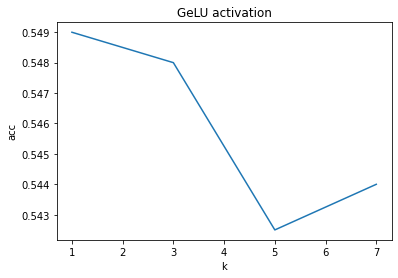

In [62]:
plt.plot((1,3,5,7), acc)
plt.title('GeLU activation')
plt.xlabel('k')
plt.ylabel('acc')
plt.show()

# 7

Reuse data in problem 6

## (a)

As per lines $\verb|939|$ to $\verb|941|$ in [`linear.py`](https://github.com/google/neural-tangents/blob/main/neural_tangents/_src/stax/linear.py), `out_chan` is ignored in `ntk` mode.

In [7]:
_, _, ker_fn_1 = stax.serial(
    stax.Conv(out_chan=16, filter_shape=(3,3), strides=(2,2)), stax.Relu(),
    stax.Flatten(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_3 = stax.serial(
    stax.Conv(out_chan=16, filter_shape=(3,3), strides=(2,2)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Flatten(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_5 = stax.serial(
    stax.Conv(out_chan=16, filter_shape=(3,3), strides=(2,2)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Flatten(),
    stax.Dense(out_dim=10)
)
_, _, ker_fn_7 = stax.serial(
    stax.Conv(out_chan=16, filter_shape=(3,3), strides=(2,2)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Conv(out_chan=16, filter_shape=(3,3)), stax.Relu(),
    stax.Flatten(),
    stax.Dense(out_dim=10)
)

ker_fn_1 = jit(ker_fn_1, static_argnames='get')
ker_fn_3 = jit(ker_fn_3, static_argnames='get')
ker_fn_5 = jit(ker_fn_5, static_argnames='get')
ker_fn_7 = jit(ker_fn_7, static_argnames='get')

In [8]:
pred_fn_1 = nt.predict.gradient_descent_mse_ensemble(ker_fn_1,
                                                     X_train, y_train)
pred_fn_3 = nt.predict.gradient_descent_mse_ensemble(ker_fn_3,
                                                     X_train, y_train)
pred_fn_5 = nt.predict.gradient_descent_mse_ensemble(ker_fn_5,
                                                     X_train, y_train)
pred_fn_7 = nt.predict.gradient_descent_mse_ensemble(ker_fn_7,
                                                     X_train, y_train)
mean_1 = pred_fn_1(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_3 = pred_fn_3(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_5 = pred_fn_5(x_test=X_test,
                   get='ntk', compute_cov=False)
mean_7 = pred_fn_7(x_test=X_test,
                   get='ntk', compute_cov=False)
acc = []
acc.append(jnp.sum(jnp.sum((mean_1 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_3 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_5 > .5) == (y_test > .5), axis=1) == 10) / 2000)
acc.append(jnp.sum(jnp.sum((mean_7 > .5) == (y_test > .5), axis=1) == 10) / 2000)

XlaRuntimeError: ignored

In [ ]:
plt.plot((1,3,5,7), acc)
plt.title('CNTK')
plt.xlabel('k')
plt.ylabel('acc')
plt.show()